# RQ-Model test

Импорт модуля для моделирования 

In [ ]:
import q_analysis.simulation as rq

Моделирование производится при помощи объекта `Model`. В нем буду содержаться элементы ( входящий поток, приборы, орбиты и т.д.)

In [ ]:
model = rq.Model()
model

Далее зададим время начала и конца моделирования в условных единицах

In [ ]:
model.set_time(0) 
model.set_end(1000000)

Далее добавим элементы модели (метод `add_producer`). В данном случае моделируется RQ-система с вызываемыми заявками.

В модель добавятся следующие элементы: 

- MMPP поток
- Орбита с экспоненциальной задержкой
- Простейший поток с экспоненциальной задержкой (будет использоваться как источник вызываемых заявок прибора)
- Обслуживающий прибор с экспоненциальным временем обслуживания входящих и вызываемых заявок

Чтобы обращаться к элементам модели, им даются ярлыки - `input`, `call`, `orbit`, `node`

Все объекты и функции библиотеки имеют описание, доступное при помощи `__doc__`

In [ ]:
print(model.add_producer.__doc__)

Также можно посмотреть доступные объекты библиотеки и содержимое любого объекта при помощи `dir`

In [ ]:
model.add_producer(rq.MMPPInput(
    [1,1.12,0.45],
    [[ -0.4, 0.3, 0.1],
    [0.5,-0.6,0.1],
    [0.3,0.6,-0.9]],0,0),"input")
model.add_producer(rq.SimpleInput(rq.ExponentialDelay(1),1,0),"call")
model.add_producer(rq.Orbit(rq.ExponentialDelay(1)),"orbit")
model.add_producer(rq.RqtNode(rq.ExponentialDelay(1.15),rq.ExponentialDelay(1.15)),"node")
print("Components:",model.components())

Далее требуется соединить элементы модели при помощи маршрутизаторов.

Для этого используется метод `add_connection`. 

В параметрах указывается ранее заданный ярлык элемента модели, потом его вход\выход, функция возвращает ярлык соединения

In [ ]:
model.add_connection("input","out_slot","node","in_slot")

В данном случае мы указали входящий поток `input` и его выход `out_slot` как источник заявок, и прибор `node` и его вход `in_slot` как вход для приходящих заявок.

Далее добавляются остальные соединения

In [ ]:
#Init connections

model.add_connection("call","out_slot","node","call_slot")
model.add_connection("node","orbit_append_slot","orbit","in_slot")
orb = model.add_connection("orbit","out_slot","node","orbit_slot")
output = model.add_hanging_output_noqueue("node","out_slot")

print("Connections",model.routers())

Чтобы посмотреть список доступных входов и выходов элемента используются методы `inputs` и `outputs` соответственно

In [ ]:
model.component_at('node').inputs()

In [ ]:
model.component_at('node').outputs()

После того, как заявка успешно обслужится на приборе, она попадает в маршрутизатор без очереди (`add_hanging_output_noqueue`). Этот тип маршрутизатора отличается тем, что заявки в нем не хранятся, а лишь читаются при появлении.

Для чтения заявок в маршрутизаторах и сбора статистики о их перемещении используется класс объектов `RouterReader`, которые прикрепляются к маршрутизатору и читают извлекаемые из него заявки. К одному маршрутизатору может быть прикреплено несколько таких объектов, что позволяет собирать статистику разного типа.

На данный момент в библиотеке есть `AttemptCounter` - учитывает количество попыток и время ожидания каждой заявки, `IntervalRouterReader` - собирает статистику по обслуженным заявкам в заданном временном интервале.

Чтобы добавить сбор статистики на маршрутизатор используется его метод модели `add_connection_reader`. Ярлык выходного маршрузитизатора уже лежит в переменной `output`

In [ ]:
output

Ярлыки маршрузиторов называются по следующей схеме:

`ярлык выходного элемента` :  `имя выхода` :  `ярылк входного элемента` : `имя входа`

Для аккумулирующего входного маршрузитора (`model.add_hanging_input`):

`i` :  `ярылк входного элемента` : `имя входа`

Для аккумулирующего выходного маршрузитора (`model.add_hanging_output`):

`o` :  `ярылк выходного элемента` : `имя выхода`

Для выходного маршрузитора (`model.add_hanging_output_noqeuue`):

`onq` :  `ярылк выходного элемента` : `имя выхода`


Добавим сбор статистики с интервалом в 20 условных единиц для выхода прибора и подсчет попыток для входящих на прибор с орбиты заявок

In [ ]:
model.router_at(output).add_reader(rq.IntervalRouterReader(20),"stat")
#model.router_at(orb).add_reader(rq.AttemptCounter(),"count")

In [ ]:
model.router_at(output).readers()

В итоге, если изобразить полученную модель графически, получится следущее
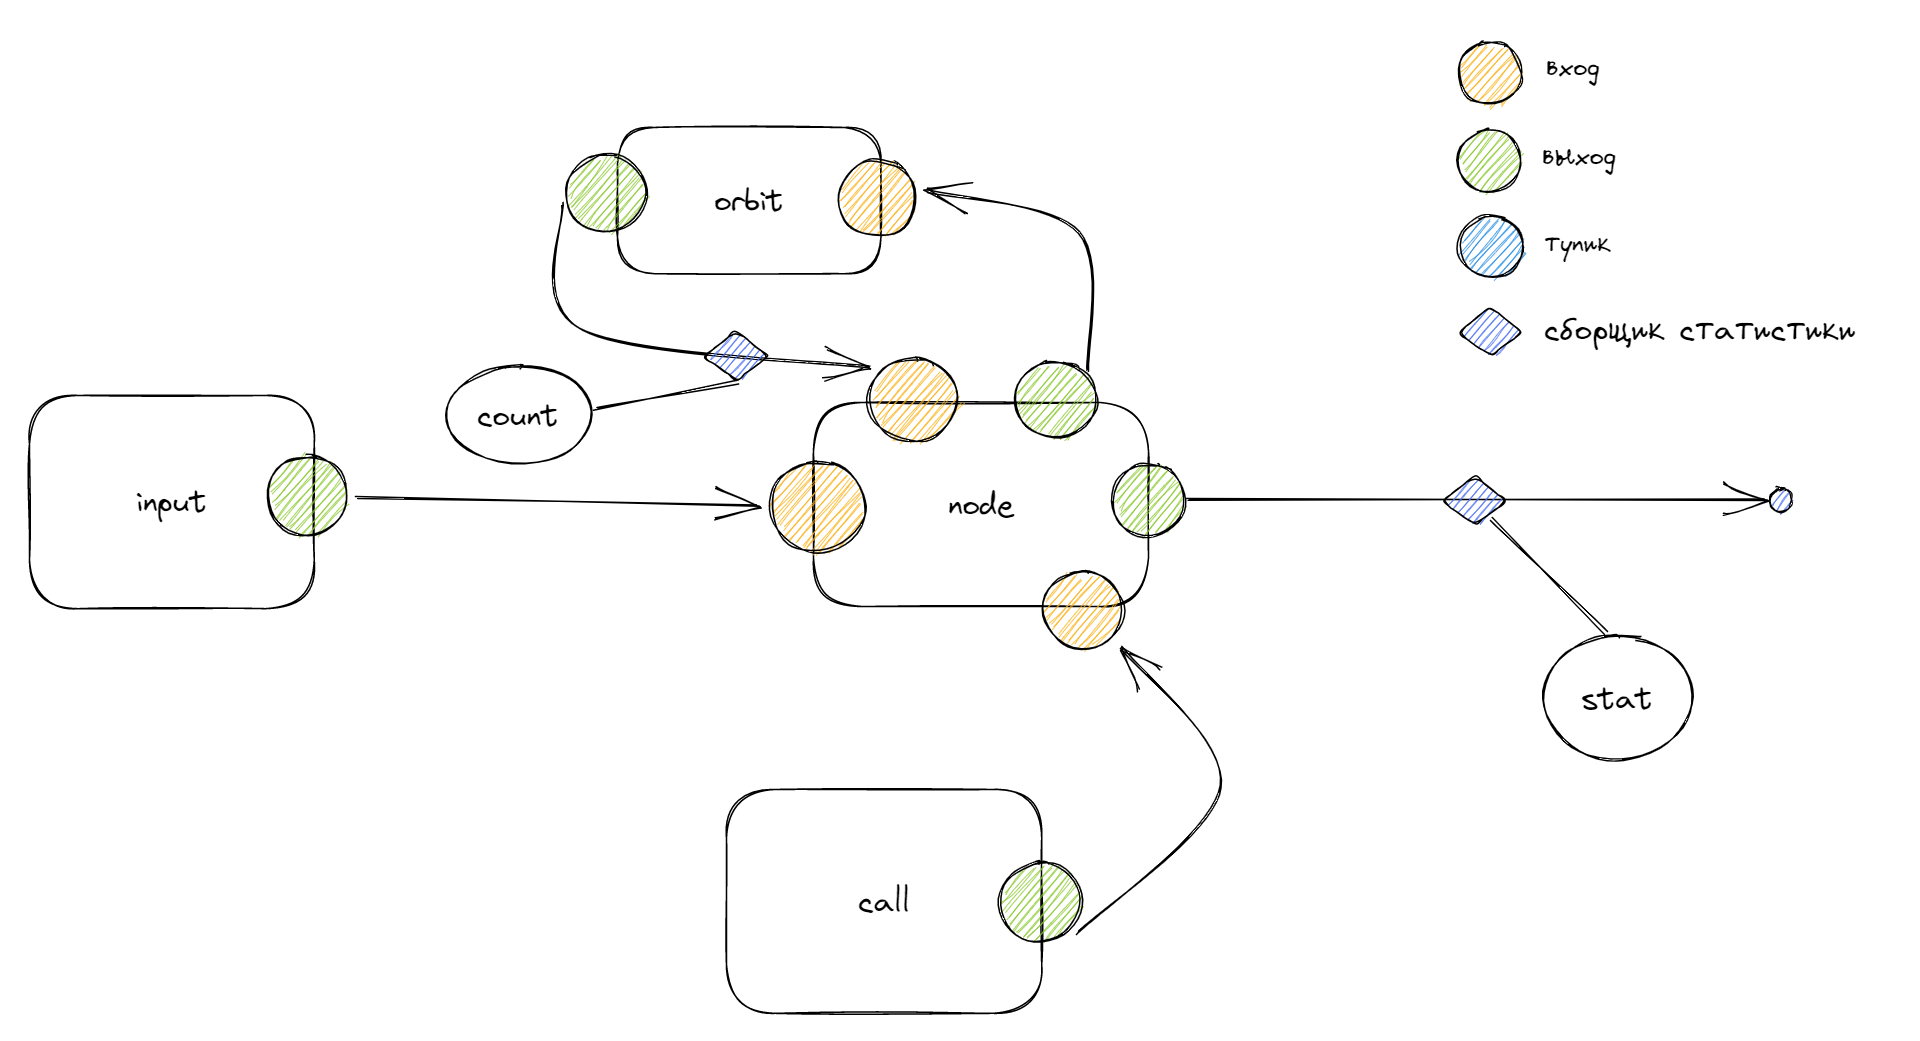

Процесс моделирования сводится к итеративному вызову метода `produce` у элементов модели с указанием в качестве параметра текущего времени моделирования. Результат работы `produce` (список событий) передаются в функцию модели `aggregate` для того, чтобы далее смещать время на нужные моменты.

 Для смещения времени моделирования используется метод модели `next_step`.

In [ ]:
from tqdm import tqdm #красивая полоска прогресса
e = model.end()
with tqdm(total=int(e)) as pbar:     
  t = c = 0
  while True:
          c+=1 
          told = t
          t = model.next_step()
          pbar.update(t-told)
          model.aggregate(model.component_at("input").produce(t))
          model.aggregate(model.component_at("orbit").produce(t))
          model.aggregate(model.component_at("call").produce(t))
          model.aggregate(model.component_at("node").produce(t))
          model.aggregate(model.component_at("orbit").append(t))
          if model.is_done():
              break

In [ ]:
print("Time: ",model.time())
print("Iters: ",c)


In [ ]:
model.routers()

Далее мы можем получить распределение выхода прибора при помощи методов сборщика статистики `stat`, который был добавлен ранее

In [ ]:
[ x for x in dir(model.router_at(output).reader_at('stat')) if 'get_' in x ]

In [ ]:
distr = model.router_at(output).reader_at('stat').get_distribution_2d()

In [ ]:
import  plotly.express as pl
import plotly.graph_objects as go
import numpy as np

In [ ]:
fig = go.Figure(data=[go.Surface(z=distr) ])

fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(title='Model 2d distribution', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

#fig.write_html('tres.html')
fig.show()

In [ ]:
print("Mean  called: {0},\nMean input: {1},\nVariation called: {2},\nVariation input: {3}".format(
model.router_at(output).reader_at('stat').get_mean_called(),
model.router_at(output).reader_at('stat').get_mean_input(),
model.router_at(output).reader_at('stat').get_variation_called(),
model.router_at(output).reader_at('stat').get_variation_input()))

In [ ]:
arr = np.array(distr)

In [ ]:
arr.tofile('1mln.csv')

In [ ]:
distr = np.fromfile('1mln.csv')

In [ ]:
#fig.write_html('tres.html')
fig.write_image('model_2d_distr.png')

In [ ]:
from q_analysis import rq_system as rq
from q_analysis import utils as u

In [ ]:
Lambda = np.mat([[1, 0,   0],
                 [0,1.12, 0],
                 [0, 0,0.45]])

Q = np.mat([[ -0.4, 0.3, 0.1],
            [0.5,-0.6,0.1],
            [0.3,0.6,-0.9]])
alpha = 1
mu1 = 1.15
mu2 = 1.15

s = rq.RQSystem(mu1, mu2, Lambda, Q, alpha)
n = len(distr)
m = len(distr[0])
distr_asymp =    s.icfft2(n,m,20)
distr_asymp = np.real(np.abs(distr_asymp))

In [ ]:
fig = go.Figure(data=[go.Surface(z=distr_asymp) ])

fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(title='Model 2d distribution', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))

#fig.write_html('tres.html')
fig.show()

In [ ]:
u.k_distance2(distr,distr_asymp)

Среднее число попыток, с которой заявка смогла попасть на прибор

In [ ]:
dd = list(model.router_at(orb).reader_at('count').attempts.values())
np.average(dd)

Распределение числа попыток до успешного обслуживания заявки

In [ ]:
import plotly.figure_factory as ff

fig = ff.create_distplot([dd], ['Число попыток до успшеного обслуживания'])
fig.show()

Среднее время ожидания заявки до обслуживания

In [ ]:
dd = list(model.router_at(orb).reader_at('count').wait_time.values())
np.average(dd)

In [ ]:
fig = ff.create_distplot([dd], ['Время ожидания до успшеного обслуживания'])
fig.show()

In [ ]:
del model

# Исследование зависимости распределения заявок на орбите и времени ожидания

## OLD

In [1]:
import q_analysis.simulation as rq
import q_analysis.utils as uu
from threading import Thread
import numpy as np
import pandas as pd
from multiprocess import Process, Manager,Pool

In [2]:
#manager = Manager()
models = []
models_desc = [] #manager.list()

In [3]:
orb_i = 'node:orbit_append_slot:orbit:in_slot'
orb_o = 'orbit:out_slot:node:orbit_slot'
output = 'onq:node:out_slot'

In [4]:
def create_model(inp_i,orb_i,node_i):
  #Создание модели
  #model = rq.Model()
  model = uu.PyModel()
  model.set_time(0) 
  model.set_end(1000)
  #Добавление элементов
  model.add_producer(rq.SimpleInput(rq.ExponentialDelay(inp_i),1,0),"input")
  model.add_producer(rq.SimpleInput(rq.ExponentialDelay(1),1,0),"call")
  model.add_producer(rq.Orbit(rq.ExponentialDelay(orb_i)),"orbit")
  model.add_producer(rq.RqtNode(rq.ExponentialDelay(node_i),rq.ExponentialDelay(1.15)),"node")
  #Добавление маршрутизаторов
  model.add_connection("input","out_slot","node","in_slot")
  model.add_connection("call","out_slot","node","call_slot")
  orb_i = model.add_connection("node","orbit_append_slot","orbit","in_slot")
  orb_o = model.add_connection("orbit","out_slot","node","orbit_slot")
  output = model.add_hanging_output_noqueue("node","out_slot")
  #Добавление сборщиков статистики
  model.router_at(orb_i).add_reader(rq.AttemptCounter(),"attempt_count")
  model.router_at(output).add_reader(rq.AttemptCounter(),"attempt_count")
  model.router_at(orb_i).add_reader(rq.TimeCounter(),"count")
  model.router_at(orb_o).add_reader(rq.TimeCounter(),"count")
  return model

In [5]:
def sim_task(i):
  model = create_model(models_desc[i]['input_intensity'],models_desc[i]['orbit_intensity'],models_desc[i]['node_intensity'])
  t = c = 0
  while True:
    c+=1 
    t = model.next_step()
    model.aggregate(model.component_at("input").produce(t))
    model.aggregate(model.component_at("orbit").produce(t))
    model.aggregate(model.component_at("call").produce(t))
    model.aggregate(model.component_at("node").produce(t))
    model.aggregate(model.component_at("orbit").append(t))
    if model.is_done():
        #model.flush()
        break
  
  r = []
  r += [(x,'i') for x in model.router_at(orb_i).reader_at("count").counts]
  r += [(x,'o') for x in model.router_at(orb_o).reader_at("count").counts]
  r.sort(key=lambda tup: tup[0])
  cur_count = 0
  cur_time = 0
  tmp = [0]*1000
# orbit_size_distrs.append( )
  for v in r:
  # while cur_count+1 > len(tmp):
    #  tmp.append(0)
    if cur_count < len(tmp):
      tmp[cur_count] += v[0] - cur_time

    cur_time = v[0]
    if v[1] == 'i':
      cur_count+=1
    if v[1] == 'o':
      cur_count-=1
  if cur_time != 0:
    upd = {
    'os_distr' : [x/cur_time for x in  tmp[:1000]],
    'os_mean':np.mean(tmp[:1000]),
    'os_std':np.std(tmp[:1000]),
    'os_q95':np.quantile(tmp[:1000],0.95),
    'os_q99':np.quantile(tmp[:1000],0.99)
    }
    models_desc[i].update(upd)
  wt =  model.router_at(orb_i).reader_at("attempt_count").wait_time
  wt = [v for k,v in wt.items()]
  wtt = np.histogram(wt, density=True,bins=list(range(0,1001)))
  upd = {
  'wt_distr': wtt[0],
  'wt_bins': wtt[1],
  'wt_mean': np.mean(wt),
  'wt_std': np.std(wt),
  'wt_q95': np.quantile(wt,0.95),
  'wt_q99': np.quantile(wt,0.99)
  }
  models_desc[i].update(upd)
  wt_alt =  model.router_at(output).reader_at("attempt_count").wait_time
  wt_alt = [v for k,v in wt_alt.items()]
  wt_altt = np.histogram(wt_alt, density=True,bins=list(range(0,1001)))
  upd = {
  'wt_alt_distr' : wt_altt[0],
  'wt_alt_bins' : wt_altt[1],
  'wt_alt_mean' : np.mean(wt_alt),
  'wt_alt_std' : np.std(wt_alt),
  'wt_alt_q95' : np.quantile(wt_alt,0.95),
  'wt_alt_q99' : np.quantile(wt_alt,0.99)
  }
  models_desc[i].update(upd)
  del model
  print('#',end='')
 


In [6]:
#input_intensity_range = np.arange(0.1, 1.5001, 0.1)
orbit_intensity_range = np.arange(0.05, 5.0001, 0.1)
#node_intensity_range = np.arange(1.6001, 2.3001, 0.1)
node_intensity = 1.6
inp = 1.1
m_index = 0
#for inp in list(input_intensity_range):
for orb in list(orbit_intensity_range):
#for nod in list(node_intensity_range):
  m = {}
  m['model_index'] = m_index
  m_index+=1
  m['input_intensity'] = inp
  m['orbit_intensity'] = orb
  m['node_intensity'] = node_intensity
  models_desc.append(m)

In [6]:
len(models_desc)


50

In [ ]:
from multiprocess.pool import ThreadPool
print('#'*(len(models_desc)-1))
r = list(range(0,len(models_desc)))
with  ThreadPool() as p:
    p.map(sim_task, r)


In [ ]:
for i in range(0,len(models)-1):
  r = []
  r += [(x,'i') for x in models[i].router_at(orb_i).reader_at("count").counts]
  r += [(x,'o') for x in models[i].router_at(orb_o).reader_at("count").counts]
  r.sort(key=lambda tup: tup[0])
  cur_count = 0
  cur_time = 0
  tmp = [0]*1000
 # orbit_size_distrs.append( )
  for v in r:
   # while cur_count+1 > len(tmp):
    #  tmp.append(0)
    if cur_count < len(tmp):
      tmp[cur_count] += v[0] - cur_time

    cur_time = v[0]
    if v[1] == 'i':
      cur_count+=1
    if v[1] == 'o':
      cur_count-=1
  if cur_time != 0:
    models_desc[i]['os_distr'] = [x/cur_time for x in  tmp[:1000]]
    models_desc[i]['os_mean'] = np.mean(tmp[:1000])
    models_desc[i]['os_median'] = np.median(tmp[:1000])
    models_desc[i]['os_max'] = np.max(tmp[:1000])
    models_desc[i]['os_min'] = np.min(tmp[:1000])
    models_desc[i]['os_q25'] = np.quantile(tmp[:1000],0.25)
    models_desc[i]['os_q50'] = np.quantile(tmp[:1000],0.5)
    models_desc[i]['os_q75'] = np.quantile(tmp[:1000],0.75)
    models_desc[i]['os_q90'] = np.quantile(tmp[:1000],0.9)
    models_desc[i]['os_q95'] = np.quantile(tmp[:1000],0.95)
    models_desc[i]['os_q99'] = np.quantile(tmp[:1000],0.99)
  wt =  models[i].router_at(orb_i).reader_at("attempt_count").wait_time
  wt = [v for k,v in wt.items()]
  wtt = np.histogram(wt, density=True,bins=list(range(0,1001)))
  models_desc[i]['wt_distr'] = wtt[0]
  models_desc[i]['wt_bins'] = wtt[1]
  models_desc[i]['wt_mean'] = np.mean(wt)
  models_desc[i]['wt_median'] = np.median(wt)
  models_desc[i]['wt_max'] = np.max(wt)
  models_desc[i]['wt_min'] = np.min(wt)
  models_desc[i]['wt_q25'] = np.quantile(wt,0.25)
  models_desc[i]['wt_q50'] = np.quantile(wt,0.5)
  models_desc[i]['wt_q75'] = np.quantile(wt,0.75)
  models_desc[i]['wt_q90'] = np.quantile(wt,0.9)
  models_desc[i]['wt_q95'] = np.quantile(wt,0.95)
  models_desc[i]['wt_q99'] = np.quantile(wt,0.99)

## SubProcess

In [ ]:
import subprocess
import json
import numpy as np
res = []
procs = []
input_intensity_range = np.arange(0.1, 1.0001, 0.1)
orbit_intensity_range = np.arange(0.05, 3.0001, 0.1)
node_intensity_range = np.arange(1.6001, 2.0001, 0.1)

completed_count = 0
m_index = 0
for inp in list(input_intensity_range):
    for orb in list(orbit_intensity_range):
        for nod in list(node_intensity_range):
            procs.append(subprocess.Popen(' '.join(['python','run.py',str(inp),str(orb),str(nod)]),shell=True))
            m_index +=1
            if m_index>100:
                procs[0].wait()
                m_index-=1
                procs.pop(0)
                completed_count+=1
                print(f'Completed: {completed_count}',end="\r",flush=True)
    

for p in procs:
    p.wait()
    completed_count+=1
    print(f'Completed: {completed_count}',end="\r",flush=True)

In [96]:
for inp in list(input_intensity_range):
    for orb in list(orbit_intensity_range):
        for nod in list(node_intensity_range):
            with open(f'results/mod_{inp}_{orb}_{nod}.json','r',encoding='utf-8') as ff:
                res.append(json.load(ff))


Sigma only

In [ ]:
import subprocess
import json
import numpy as np
res = []
procs = []
inp = 1
orbit_intensity_range = np.arange(0.05, 10.0001, 0.05)
nod = 1.5

completed_count = 0
m_index = 0

for orb in list(orbit_intensity_range):
    procs.append(subprocess.Popen(' '.join(['python','run.py',str(inp),str(orb),str(nod)]),shell=True))
    m_index +=1
    if m_index>10:
        procs[0].wait()
        m_index-=1
        procs.pop(0)
        completed_count+=1
        print(f'Completed: {completed_count}',end="\r",flush=True)
    

for p in procs:
    p.wait()
    completed_count+=1
    print(f'Completed: {completed_count}',end="\r",flush=True)

In [4]:
from os import listdir
from os.path import isfile, join
for f in [f for f in listdir('results/') if isfile(join('results/', f))]:
    with open(f'results/{f}','r',encoding='utf-8') as ff:
        res.append(json.load(ff))


Only lambda

In [25]:
import subprocess
import json
import numpy as np
res = []
procs = []
input_intensity_range = np.arange(0.1, 1.7001, 0.01)
orb = 1
#orbit_intensity_range = np.arange(0.05, 10.0001, 0.1)
nod = 1.8

completed_count = 0
m_index = 0

for inp in list(input_intensity_range):
    procs.append(subprocess.Popen(' '.join(['python','run.py',str(inp),str(orb),str(nod)]),shell=True))
    m_index +=1
    if m_index>10:
        procs[0].wait()
        m_index-=1
        procs.pop(0)
        completed_count+=1
        print(f'Completed: {completed_count}',end="\r",flush=True)
    

for p in procs:
    p.wait()
    completed_count+=1
    print(f'Completed: {completed_count}',end="\r",flush=True)

/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [26]:
from os import listdir
from os.path import isfile, join
for f in [f for f in listdir('results/') if isfile(join('results/', f))]:
    with open(f'results/{f}','r',encoding='utf-8') as ff:
        res.append(json.load(ff))


Speed test

In [43]:
import subprocess
import json
import numpy as np
res = []
procs = []
inp = 1
orbit_intensity_range = np.arange(0.05, 10.0001, 0.1)
nod = 1.5

completed_count = 0
m_index = 0

for orb in list(orbit_intensity_range):
    procs.append(subprocess.Popen(' '.join(['python','run.py',str(inp),str(orb),str(nod)]),shell=True))
    m_index +=1
    if m_index>10:
        procs[0].wait()
        m_index-=1
        procs.pop(0)
        completed_count+=1
        print(f'Completed: {completed_count}',end="\r",flush=True)
    

for p in procs:
    p.wait()
    completed_count+=1
    print(f'Completed: {completed_count}',end="\r",flush=True)

/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/root/anaconda3/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [ ]:
from os import listdir
from os.path import isfile, join
for f in [f for f in listdir('results/') if isfile(join('results/', f))]:
    with open(f'results/{f}','r',encoding='utf-8') as ff:
        res.append(json.load(ff))


In [29]:
df.to_csv('example_only_l_200k.csv')

In [35]:
import pandas as  pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
#df = pd.DataFrame(res)
df = pd.read_csv('example_only_sigma_200k.csv')

In [36]:
df = df.drop('Unnamed: 0',axis=1)

In [149]:
df.to_excel('example_200k.xlsx')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   input_intensity  100 non-null    float64
 1   orbit_intesity   100 non-null    float64
 2   node_intensity   100 non-null    float64
 3   os_distr         100 non-null    object 
 4   os_mean          100 non-null    float64
 5   os_std           100 non-null    float64
 6   os_var           100 non-null    float64
 7   os_q95           23 non-null     float64
 8   os_q99           100 non-null    float64
 9   wt_distr         100 non-null    object 
 10  wt_bins          100 non-null    object 
 11  wt_mean          100 non-null    float64
 12  wt_std           100 non-null    float64
 13  wt_var           100 non-null    float64
 14  wt_q95           100 non-null    float64
 15  wt_q99           100 non-null    float64
dtypes: float64(13), object(3)
memory usage: 12.6+ KB


In [135]:
from scipy import interpolate

def inttp(row):
    dd = json.loads(row['os_distr'])
    q = json.loads(row['os_q95'])[1]
    f = interpolate.interp1d( dd,list(range(0,len(dd))), fill_value='extrapolate')
    return f(q)

df['os_q95'] = df.apply(inttp,axis=1)

In [8]:
print(df[['input_intensity','node_intensity','orbit_intesity','os_mean','wt_mean','os_std','wt_std','os_var','wt_var']].head(15).to_latex(float_format="{:.3f}".format,index=False))

\begin{tabular}{rrrrrrrrr}
\toprule
 input\_intensity &  node\_intensity &  orbit\_intesity &  os\_mean &  wt\_mean &  os\_std &  wt\_std &  os\_var &  wt\_var \\
\midrule
           0.100 &           1.600 &           0.050 &    2.044 &   20.395 &   1.487 &  35.386 &   0.728 &   1.735 \\
           0.100 &           1.700 &           0.050 &    2.035 &   20.144 &   1.484 &  34.628 &   0.729 &   1.719 \\
           0.100 &           1.800 &           0.050 &    1.994 &   20.198 &   1.489 &  34.612 &   0.747 &   1.714 \\
           0.100 &           1.900 &           0.050 &    1.969 &   19.485 &   1.480 &  33.644 &   0.752 &   1.727 \\
           0.100 &           2.000 &           0.050 &    1.998 &   19.317 &   1.466 &  33.433 &   0.734 &   1.731 \\
           0.100 &           1.600 &           0.150 &    0.734 &    7.293 &   0.898 &  12.226 &   1.223 &   1.676 \\
           0.100 &           1.700 &           0.150 &    0.688 &    7.049 &   0.861 &  12.026 &   1.252 &   1.706 \\
  

/tmp/ipykernel_575/2218844580.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[['input_intensity','node_intensity','orbit_intesity','os_mean','wt_mean','os_std','wt_std','os_var','wt_var']].head(15).to_latex(float_format="{:.3f}".format,index=False))


Распределение размера орбиты

In [9]:
import warnings
warnings.simplefilter(action='ignore')

In [30]:
orb_dict = {}
for index, row in df.iterrows():
    orb_dict[str(index)] = json.loads(row['os_distr'])


df_orbit_size = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in orb_dict.items() ]))


In [11]:
df_orbit_size.describe(percentiles=[0.90,0.95,0.99])

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
std,0.014161,0.014095,0.014160,0.014185,0.014185,0.019307,0.019704,0.019718,0.019705,0.019698,...,0.011789,0.012488,0.013170,0.013638,0.014068,0.011954,0.012582,0.013191,0.013721,0.014278
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99%,0.000093,0.000081,0.000089,0.000221,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011157,0.007709,0.005768,0.004168,0.003373,0.010605,0.007526,0.005305,0.004232,0.003047
max,0.271308,0.264437,0.269933,0.274040,0.269786,0.498679,0.515296,0.520993,0.519831,0.517816,...,0.219274,0.245067,0.274261,0.295422,0.314823,0.228042,0.250377,0.277086,0.301025,0.323850


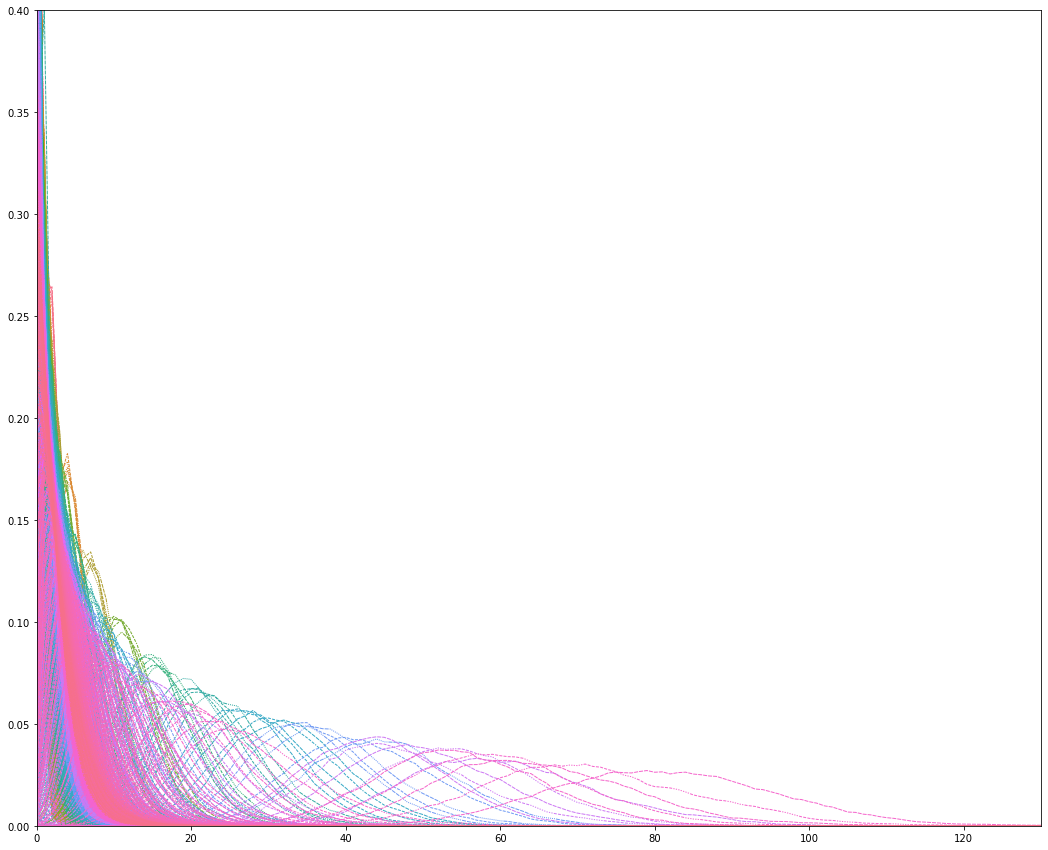

In [12]:
fig, ax = plt.subplots(figsize=(18, 15))
fig = sns.lineplot( data=df_orbit_size,lw=1,legend=False,ax=ax)
ax.set_xlim(0, 130)
ax.set_ylim(0, 0.4)
plt.show()

Распределение времени ожидания

In [23]:
wait_dict = {}
for index, row in df.iterrows():
    wait_dict[str(index)] = json.loads(row['wt_distr'])

df_wait_time = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in wait_dict.items() ]))

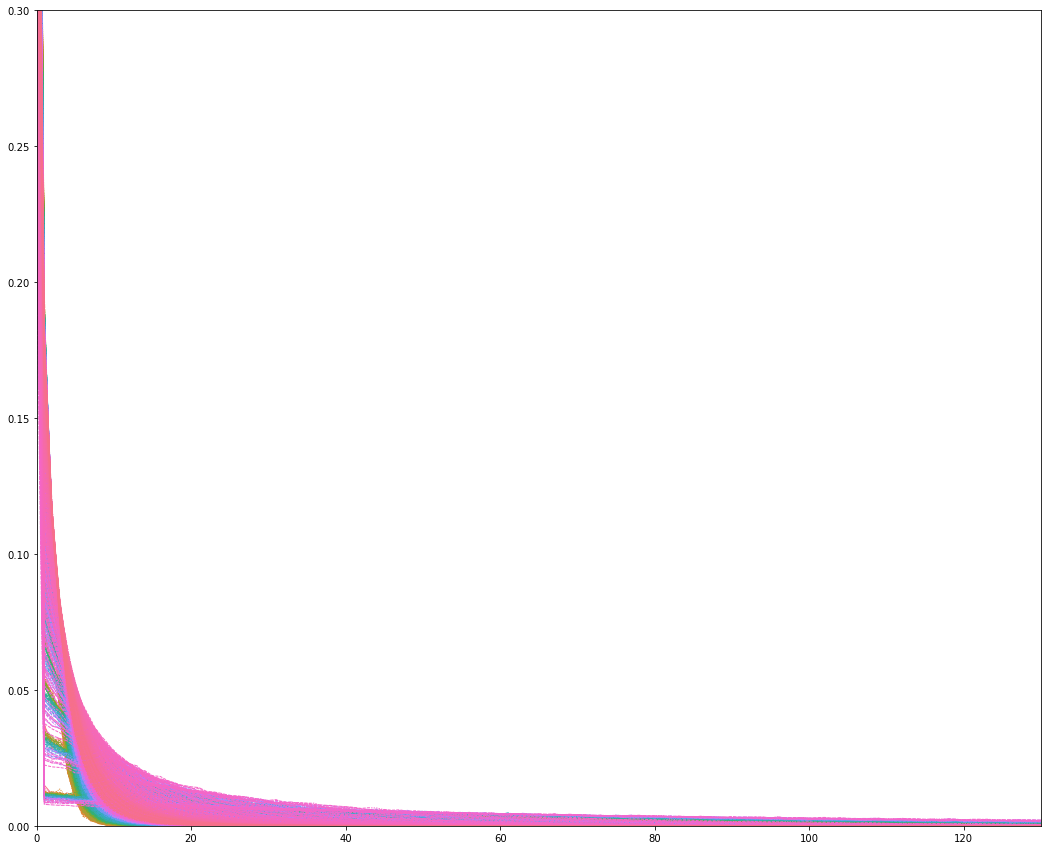

In [14]:
fig, ax = plt.subplots(figsize=(18, 15))
fig = sns.lineplot( data=df_wait_time,lw=1,legend=False,ax=ax)
ax.set_xlim(0, 130)
ax.set_ylim(0, 0.3)
plt.show()

In [38]:
df_scatter =  df.select_dtypes(include=['float64','int64'])[[
'os_mean',
'os_std',              
#'os_q95',     
#'os_q99',
'os_var',
'wt_mean',  
'wt_std',
'wt_var',        
#'wt_q95',     
#'wt_q99',  
]]

In [39]:
df_scatter = df_scatter.dropna(axis=0)
df_scatter = df_scatter.reset_index(drop=True)

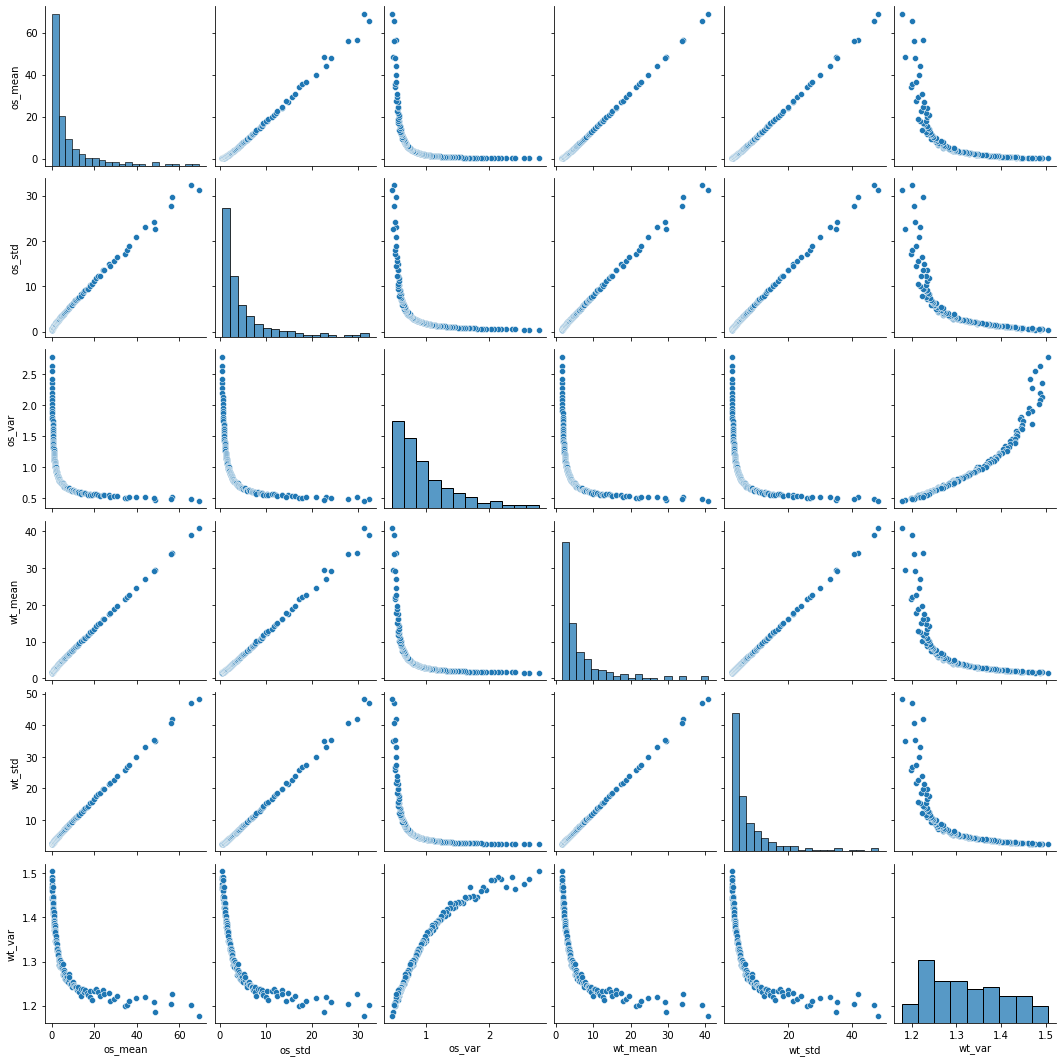

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_scatter)
plt.show()

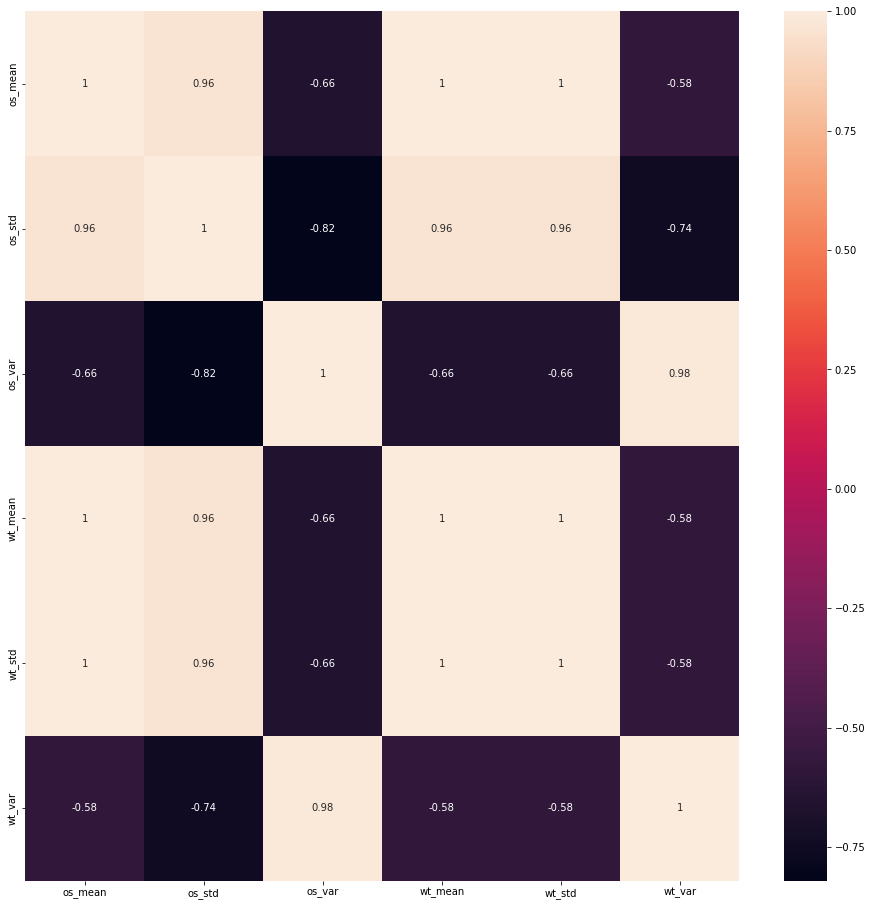

In [40]:
kol_corr_pirson = df_scatter.corr(method='pearson')
plt.figure(figsize = (16,16))
sns.heatmap(kol_corr_pirson[abs(kol_corr_pirson)>0.0], annot = True);

# Prototype

In [41]:
from q_analysis import simulation as rq
#Создание модели
model = Model()
model.set_time(0) 
model.set_end(100000)
#Добавление элементов
model.add_producer(rq.SimpleInput(rq.ExponentialDelay(1),1,0),"input")
model.add_producer(rq.SimpleInput(rq.ExponentialDelay(1),1,0),"call")
model.add_producer(rq.Orbit(rq.ExponentialDelay(1.4)),"orbit")
model.add_producer(rq.RqtNode(rq.ExponentialDelay(1.15),rq.ExponentialDelay(1.15)),"node")
print("Components:",model.components)
#Добавление маршрутизаторов
model.add_connection("input","out_slot","node","in_slot")
model.add_connection("call","out_slot","node","call_slot")
orb_i = model.add_connection("node","orbit_append_slot","orbit","in_slot")
orb_o = model.add_connection("orbit","out_slot","node","orbit_slot")
output = model.add_hanging_output_noqueue("node","out_slot")

print("Connections",model.routers)
#Добавление сборщиков статистики
model.router_at(orb_i).add_reader(rq.AttemptCounter(),"attempt_count")
model.router_at(orb_i).add_reader(rq.TimeCounter(),"count")
model.router_at(orb_o).add_reader(rq.TimeCounter(),"count")
print ("Readers",  model.router_at(orb_i).readers())
print ("Readers",  model.router_at(orb_o).readers())

Components: {'input': SimpleInput, 'call': SimpleInput, 'orbit': Orbit, 'node': RQTNode}
Connections {'input:out_slot:node:in_slot': Router{ queue_len: 0 }, 'call:out_slot:node:call_slot': Router{ queue_len: 0 }, 'node:orbit_append_slot:orbit:in_slot': Router{ queue_len: 0 }, 'orbit:out_slot:node:orbit_slot': Router{ queue_len: 0 }, 'onq:node:out_slot': Router{ queue_len: 0 }}


KeyError: None

In [ ]:
#from tqdm import tqdm #красивая полоска прогресса
#e = model.end()
#with tqdm(total=int(e)) as pbar:     
t = c = 0
while True:
        c+=1 
        told = t
        t = model.next_step()
      #   pbar.update(t-told)
        model.aggregate(model.component_at("input").produce(t))
        model.aggregate(model.component_at("orbit").produce(t))
        model.aggregate(model.component_at("call").produce(t))
        model.aggregate(model.component_at("node").produce(t))
        model.aggregate(model.component_at("orbit").append(t))
        if model.is_done():
            break

print("\nTime: ",model.time())
print("Iters: ",c)


In [ ]:
raw_data = []
raw_data += [(x,'i') for x in model.router_at(orb_i).reader_at("count").counts]
raw_data += [(x,'o') for x in model.router_at(orb_o).reader_at("count").counts]

raw_data.sort(key=lambda tup: tup[0])

cur_count = 0
cur_time = 0
orbit_size_distr = [0] * 1000

for v in raw_data:
  if cur_count < len(orbit_size_distr):
    orbit_size_distr[cur_count] += v[0] - cur_time
  cur_time = v[0]
  if v[1] == 'i':
    cur_count+=1
  if v[1] == 'o':
    cur_count-=1
  
orbit_size_distr =[x/cur_time for x in  orbit_size_distr[:1000]]

In [ ]:
import pandas as pd

df1 = pd.DataFrame(orbit_size_distr,columns=['distr'])

In [ ]:
import plotly.express as px
fig = px.line(df1, x=df1.index, y="distr",
                   hover_data=df1.columns)
fig.show()

In [ ]:
wait_times =  model.router_at(orb_i).reader_at("attempt_count").wait_time
wait_times = [v for k,v in wait_times.items()]

In [ ]:
df2 = pd.DataFrame(wait_times,columns=['vals'])

In [ ]:
dd = df2.plot.kde()

In [ ]:
fig = ff.create_distplot([wait_times], ['Распределение времени ожидания до успшеного обслуживания'])
fig.show()

In [ ]:
df2.describe()

In [ ]:
df1.describe()